# Classification with Reservoir Computing

Reservoir Computing (RC) is well suited to both regression and classification tasks. In the following notebook, you will experiment with a simple example of classification task.

In [1]:
import os
print(os.getcwd())

/Users/deep/Projects/reservoirpy/tutorials


In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from reservoirpy.datasets import japanese_vowels
from reservoirpy import set_seed, verbosity
from reservoirpy.observables import nrmse, rsquare

from sklearn.metrics import accuracy_score

set_seed(42)
verbosity(0)

0

## Classification - The Japanese vowel dataset

The Japanese vowel dataset is composed of 640 utterances of the Japanese vowel `\ae\`, from 9 different male speakers. The goal of this task is to assign to each utterance the label of its speaker. Dataset is split between a 270 utterances training set and a 340 utterances testing set.

Each spoken utterance is a timeseries of 7~29 timesteps. Each timestep of signal is a 12 dimensional vector representing Linear Prediction Coefficient (LPC), which encode the audio signal into the cepstral domain (a variant of the frequency domain).


### References

M. Kudo, J. Toyama and M. Shimbo. (1999). "Multidimensional Curve Classification Using Passing-Through Regions". Pattern Recognition Letters, Vol. 20, No. 11--13, pages 1103--1111.

https://archive.ics.uci.edu/ml/machine-learning-databases/JapaneseVowels-mld/

In [3]:
X_train, Y_train, X_test, Y_test = japanese_vowels()

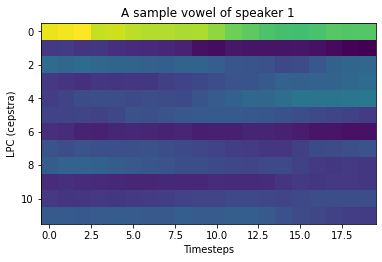

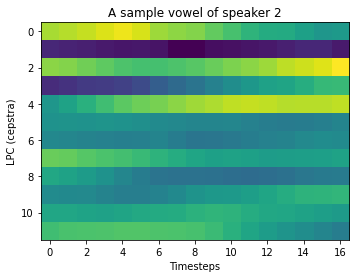

In [4]:
plt.imshow(X_train[0].T)
plt.title(f"A sample vowel of speaker {np.argmax(Y_train[0]) +1}")
plt.xlabel("Timesteps")
plt.ylabel("LPC (cepstra)")
plt.show()

plt.imshow(X_train[50].T)
plt.title(f"A sample vowel of speaker {np.argmax(Y_train[50]) +1}")
plt.xlabel("Timesteps")
plt.ylabel("LPC (cepstra)")
plt.show()

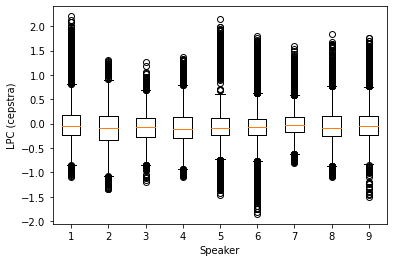

In [5]:
sample_per_speaker = 30
n_speaker = 9
X_train_per_speaker = []

for i in range(n_speaker):
    X_speaker = X_train[i*sample_per_speaker: (i+1)*sample_per_speaker]
    X_train_per_speaker.append(np.concatenate(X_speaker).flatten())

plt.boxplot(X_train_per_speaker)
plt.xlabel("Speaker")
plt.ylabel("LPC (cepstra)")
plt.show()

## Transduction (sequence-to-sequence model)

As ReservoirPy Nodes are built to work on sequences, the simplest setup to solve this task is *sequence-to-sequence encoding*, also called *transduction*. A model is trained on encoding each vector of input sequence into a new vector in the output space. Thus, a sequence of audio yields a sequence of label, one label per timestep.

In [6]:
# repeat_target ensure that we obtain one label per timestep, and not one label per utterance.
X_train, Y_train, X_test, Y_test = japanese_vowels(repeat_targets=True)

### Train a simple Echo State Network to solve this task:

In [7]:
from reservoirpy.nodes import Reservoir, Ridge, Input

In [8]:
source = Input()
reservoir = Reservoir(500, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-6)

model = [source >> reservoir, source] >> readout

Fit the model:

In [9]:
Y_pred = model.fit(X_train, Y_train, stateful=False, warmup=2).run(X_test, stateful=False)

Get the scores:

There are 9 speakers, hence the output space is 9-dimensional. The speaker label is the index of the output neuron with maximum activation.

In [10]:
Y_pred_class = [np.argmax(y_p, axis=1) for y_p in Y_pred]
Y_test_class = [np.argmax(y_t, axis=1) for y_t in Y_test]

score = accuracy_score(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0))

print("Accuracy: ", f"{score * 100:.3f} %")

Accuracy:  91.173 %


## Classification (sequence-to-vector model)

We can create a more elaborated model where inference is performed only once on the whole input sequence. Indeed, we only need to assign one label to each input sequence. This new setup is known as a *sequence-to-vector* model, and this is usually the type of model we refer to when talking about classification of sequencial patterns.

In [11]:
X_train, Y_train, X_test, Y_test = japanese_vowels()

In [12]:
from reservoirpy.nodes import Reservoir, Ridge, Input

In [13]:
source = Input()
reservoir = Reservoir(500, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-6)

model = source >> reservoir >> readout

We need to modify the training loop by hand a bit to perform this task:
- first, we compute all reservoir states over the input sequence using the `reservoir.run` method.
- then, we gather in a list only the last vector of the states sequence.

In [14]:
states_train = []
for x in X_train:
    states = reservoir.run(x, reset=True)
    states_train.append(states[-1, np.newaxis])

We can now train the readout only on the last state vectors. Here, `Y_train` is an array storing a single label for each utterance.

In [15]:
readout.fit(states_train, Y_train)

'Ridge-1': Ridge(ridge=1e-06, input_bias=True, in=500, out=9)

We also modify the inference code using the same method as above:

In [16]:
Y_pred = []
for x in X_test:
    states = reservoir.run(x, reset=True)
    y = readout.run(states[-1, np.newaxis])
    Y_pred.append(y)

In [17]:
Y_pred_class = [np.argmax(y_p) for y_p in Y_pred]
Y_test_class = [np.argmax(y_t) for y_t in Y_test]

score = accuracy_score(Y_test_class, Y_pred_class)

print("Accuracy: ", f"{score * 100:.3f} %")

Accuracy:  92.432 %
